# Step 0: Download data

In [1]:
import numpy as np
import scipy as sp
import scipy.special as spsp
import matplotlib.pyplot as plt

# Fetch MNIST dataset
from sklearn.datasets import fetch_openml
mnist_data = fetch_openml('mnist_784')
mnist_data_x = (mnist_data['data']+0.5)/256.0
mnist_data_y = mnist_data['target'].astype('int8')

data_dim = mnist_data_x.shape[1]

## Split data into training and validation

In [2]:
def display_mnist_digit(x,lbl=None):
  plt.imshow(x.reshape(28,28))
  plt.xticks([])
  plt.yticks([])
  if lbl is not None:
    plt.title(lbl)

def binary_mnist(c1,c0,N_train=200,N_val=200,seed=0):
  mask = np.logical_or(mnist_data_y == c1,mnist_data_y == c0)
  mnistbin_x = mnist_data_x[mask,:]
  mnistbin_y = mnist_data_y[mask] == c1 # label is true if digit is a 9, otherwise false
  
  num_data = mnistbin_x.shape[0]
  rp = np.random.permutation(num_data)

  # Split the data into training and validation
  train_x = mnistbin_x[rp[:N_train]]
  train_y = mnistbin_y[rp[:N_train]]
  val_x = mnistbin_x[rp[N_train:(N_train+N_val)]]
  val_y = mnistbin_y[rp[N_train:(N_train+N_val)]]

  return train_x,train_y,val_x,val_y

mnistbin_train_x,mnistbin_train_y,mnistbin_val_x,mnistbin_val_y = binary_mnist(9,4)

# Step 1: Explore the data

**QUESTION**

59.5% of the training data is class True, corresponding to 119 data points


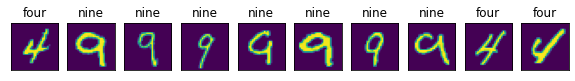

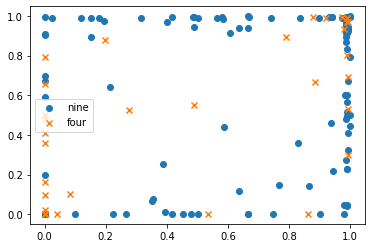

In [3]:
# Print statistics
print('{}% of the training data is class True, corresponding to {} data points'.format(100*np.sum(mnistbin_train_y)/len(mnistbin_train_y),np.sum(mnistbin_train_y)))

# Visualize a few images
np.random.seed(0)
num_digits = 10
plt.figure(figsize=(10,5))
for i in range(num_digits):
  ind = np.random.randint(0,mnistbin_train_x.shape[0])
  plt.subplot(1,num_digits,i+1)
  display_mnist_digit(mnistbin_train_x[ind,:],
                      'nine' if mnistbin_train_y[ind] else 'four')

# Construct a scatter plot of two arbitrary dimensions
vis_dims = (211,238)
plt.figure()
plt.scatter(mnistbin_train_x[mnistbin_train_y==True][:,vis_dims[0]],
            mnistbin_train_x[mnistbin_train_y==True][:,vis_dims[1]],
            marker='o', label='nine')
plt.scatter(mnistbin_train_x[mnistbin_train_y==False][:,vis_dims[0]],
            mnistbin_train_x[mnistbin_train_y==False][:,vis_dims[1]],
            marker='x', label='four')
plt.legend()



# Step 2: Implement Logistic Regression

## Implement the sigmoid and log-sigmoid functions
Here we implement the sigmoid function to test that things are working properly.

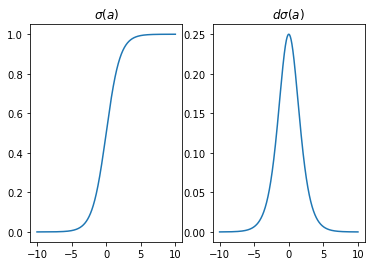

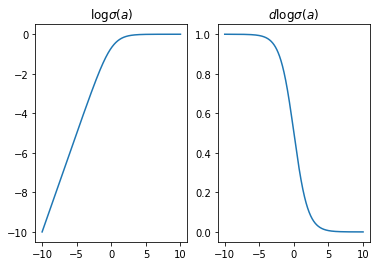

In [4]:
def sigmoid(a):
  # Implement the sigmoid function 1/(1+exp(-a)) and its derivative
  #
  # Input: a - Vector of values
  # Output: s,ds
  #   s - Vector of sigmoid function evaluated at the values in a
  #  ds - Vector of the derivatives of the sigmoid evaluated at the values of a
  #
  # TODO: Implement this function.  Your implementation should be not just be a 
  # call to np.exp() wrapped around your implementation of log_sigmoid().
  # Rather, you should expand and simplify the expressions of the sigmoid
  # function and it's derivatives.
  #
  # NOTE: you may only use basic exp/log functions from numpy here.  Only
  # np.exp, np.log, np.log1p, np.log1m, along with basic arithmetic are allowed
  # in your implementation.
  s = np.exp(a)/(1+np.exp(a))
  ds = np.exp(a)/((1+np.exp(a))**2)
  return s, ds

def log_sigmoid(a):
  # Implement the log sigmoid function log(1/(1+exp(-a))) and its derivative
  #
  # Input: a - Vector of values
  # Output: logs,dlogs
  #   logs - Vector of log sigmoid function evaluated at the values in a
  #  dlogs - Vector of the derivatives of the logsigmoid evaluated at the values of a
  #
  # TODO: Implement this function.  Your implementation should be not just be a 
  # call to np.log() wrapped around your implementation of sigmoid().  Rather,
  # you should expand and simplify the expressions of the log sigmoid function
  # and it's derivatives.
  #
  # NOTE: you may only use basic exp/log functions from numpy here.  Only
  # np.exp, np.log, np.log1p, np.log1m, along with basic arithmetic are allowed
  # in your implementation.
  logs = a - np.log(np.exp(a)+1)
  dlogs = 1/(np.exp(a)+1)

  return logs, dlogs

def test_sigmoid_impl():
  # These are sanity checks, not exhaustive unit tests.  These may pass but you
  # may still have bugs.  However, if these don't pass you almost certainly have
  # bugs.

  avals = [-5,0,1]
  for a in avals:
    sa, dsa = sigmoid(a)
    lsa, dlsa = log_sigmoid(a)

    # VERY IMPORTANT: spsp.expit() should only be used for testing here.  You 
    # are expected to implement the sigmoid and logsigmoid directly in terms of
    # the numpy functions mentioned above.
    assert np.abs(sa - spsp.expit(a)) < 1e-8
    assert np.abs(lsa - np.log(sa)) < 1e-8
    assert np.abs(dlsa - (1.0/sa)*dsa) < 1e-8

    eps = 1e-10
    dsa_fd = (sigmoid(a+eps)[0] - sigmoid(a-eps)[0])/(2*eps)
    dlsa_fd = (log_sigmoid(a+eps)[0] - log_sigmoid(a-eps)[0])/(2*eps)
    assert np.abs(dsa-dsa_fd) < 1e-6
    assert np.abs(dlsa-dlsa_fd) < 1e-6

  ina = np.linspace(-10,10,1000)
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(ina,sigmoid(ina)[0])
  plt.title('$\sigma(a)$')
  plt.subplot(1,2,2)
  plt.plot(ina,sigmoid(ina)[1])
  plt.title('$d \sigma(a)$')

  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(ina,log_sigmoid(ina)[0])
  plt.title('$\log \sigma(a)$')
  plt.subplot(1,2,2)
  plt.plot(ina,log_sigmoid(ina)[1])
  plt.title('$d \log \sigma(a)$')
  
test_sigmoid_impl()

## Implement logistic regression log probability and loss
Use the above sigmoid and log-sigmoid functions to implement logistic regression log probability and loss functions

In [5]:
def logregr_logprob(x,theta):
  # Compute the log probility of the input belonging to class 1 for a
  # logistic regression model with parameters theta
  #
  # Input:
  #       x - a NxD array of N training examples with dimension D
  #   theta - a (D+1)x1 array of parameters.  The first D are the weights of
  #           each input dimenion (w).  The last entry is the bias (b).
  #
  # Output: lp
  #     lp - an Nx2 vector of log likelihoods of class 0 and class 1 given x
  #
  # TODO: Implement this function.  You should use your implementations of
  # the sigmoid and log_sigmoid functions above.
  b = theta[len(theta)-1]
  w = theta[: -1]
  
  theta_new = np.matmul(w, np.transpose(x))+b
  p1 = 1/(1+np.exp(-theta_new))
  
  p0 = 1/(1+np.exp(theta_new))

  lp1 = np.log(p1)
  lp0 = np.log(p0)
  
  lp=np.vstack((lp0,lp1)).T
  
  return lp

def logregr_loss(x,y,theta,lmbda=0):
  # Compute the negative log likelihood of a set of training samples for a
  # logistic regression model with regularization parameter lambda
  #
  # Input:
  #       x - a NxD array of N training examples with dimension D
  #       y - a Nx1 array with true/false (1/0) labels for each training example
  #   theta - a (D+1)x1 array of parameters.  The first D are the weights of
  #           each input dimenion (w).  The last entry is the bias (b).
  #  lambda - a scalar indicating the strength of the regularization
  #
  # Output: loss, grad, acc
  #     loss - scalar,  negative log likelihood of training data
  #    grad - a (D+1)x1 vector with the gradient gradient of negative log
  #         - likelihood with respect to theta
  #     acc - scalar, accuracy of the currect value of theta on the data
  #           computed by counting what fraction of times the correct class is 
  #           given a probability > 0.5 (or log probability > log(0.5)).
  #
  # TODO: Implement this function.  You should use your implementations of
  # the sigmoid and log_sigmoid functions above.
  b = theta[len(theta)-1]
  w = theta[:-1]
  theta_new = np.matmul(x,np.transpose(w))+b
  
  loss = -(np.matmul(y, log_sigmoid(theta_new)[0]) + np.matmul((1-y), log_sigmoid(-theta_new)[0])) + (lmbda/2)*np.matmul(np.transpose(w),w)
  
  sum = np.zeros(len(theta)-1)   
  sum = np.matmul((y-sigmoid(np.matmul(x,np.transpose(w))+b)[0]),x)

  dw = (lmbda*w - sum)
  db = - np.sum((y-sigmoid(theta_new)[0]))
  dloss = np.append(dw,db)
  acc = 0.0
  acc_count = 0
  lps = logregr_logprob(x,theta)
  
  acc_count = np.sum(lps[y == False, 0] >  np.log(0.5)) + np.sum(lps[y == True, 1] >  np.log(0.5))
  acc = acc_count/len(y)

  return loss, dloss, acc

def test_logregr_logprob():
  # These are sanity checks, not exhaustive unit tests.  These may pass but you
  # may still have bugs.  However, if these don't pass you almost certainly have
  # bugs.
  
  # Predicted probabilities in this case should be [0.5,0.5]
  assert np.all(np.abs(np.log(0.5) - logregr_logprob(np.zeros((1,1)), np.zeros((2)))) < 1e-8)
  # Predicted probabilities in this case should be approximately [0,1]
  assert np.all(np.abs(np.array([-100,0]) - logregr_logprob(np.zeros((1,1)), np.array([0,100]))[0]) < 1e-8)
  # Predicted probabilities in this case should be approximately [1,0]
  assert np.all(np.abs(np.array([0,-100]) - logregr_logprob(np.zeros((1,1)), np.array([0,-100]))[0]) < 1e-8)

  np.random.seed(0)
  test_N = 10
  test_D = 4
  test_x = np.random.randn(test_N,test_D)
  test_y = np.random.rand(test_N) > 0.5
  test_theta = np.concatenate((np.random.randn(test_D),np.random.randn(1)),axis=0)
  test_loss, test_dloss, _ = logregr_loss(test_x,test_y,test_theta)
  
  # loss should be negative sum of logprob
  lps = logregr_logprob(test_x,test_theta)
  

  assert np.abs(-np.sum((1-test_y)*lps[:,0] + test_y*lps[:,1]) - test_loss) < 1e-8
  
  # central difference approximation of the gradient should be fairly accurate
  test_loss, test_dloss, _ = logregr_loss(test_x,test_y,test_theta,lmbda=1)
  eps = 1e-8
  test_dloss_fd = np.empty_like(test_dloss)
  for i in range(test_theta.shape[0]):
    test_theta0 = np.copy(test_theta)
    test_theta0[i] -= eps
    test_theta1 = np.copy(test_theta)
    test_theta1[i] += eps
    test_loss0 = logregr_loss(test_x,test_y,test_theta0,lmbda=1)[0]
    test_loss1 = logregr_loss(test_x,test_y,test_theta1,lmbda=1)[0]
    test_dloss_fd[i] = (test_loss1 - test_loss0)/(2*eps)
  

  assert np.allclose(test_dloss,test_dloss_fd)
  
test_logregr_logprob()

## Implement Gradient Descent for logistic regression

In [6]:
def fit_logregr(train_x,train_y,val_x,val_y,lmbda,quiet=True):

  N,D = train_x.shape

  theta = 0.1*np.random.randn(D+1)
  
  loss, dloss, acc = logregr_loss(train_x,train_y,theta,lmbda)
  loss_val, _, acc_val = logregr_loss(val_x,val_y,theta,lmbda)
  
  losss_train = [loss]
  dlosss_train = [(dloss**2).sum()]
  
  accs_train = [acc]
  losss_val = [loss_val]
  accs_val = [acc_val]
  step_size = 1e-6
  
  for it in range(300):
    if not quiet and it % 10 == 0:
      print('it {}: loss = {:.4}, acc = {:.2}, ||dloss||^2 = {:.4}, step_size = {:.4}'.format(it, loss, acc, (dloss**2).sum(), step_size))
      print('       loss_val = {:.4f}, acc_val = {:.2f}'.format(loss_val, acc_val))

    # TODO: Use the logregr_loss function to implement this portion of code.
    # You should aim for efficiency of your implementation here and avoid extra
    # calls to logregr_loss for values that have already been computed.
    
    step_size = step_size * (1.5)
    
    while logregr_loss(train_x,train_y,theta - step_size * dloss, lmbda)[0] >= loss:
      step_size = 0.5*step_size
    theta = theta - step_size * dloss
    
    loss, dloss, acc = logregr_loss(train_x,train_y,theta,lmbda)
    loss_val, _, acc_val = logregr_loss(val_x,val_y,theta,lmbda)
    # NOTE: by this point loss, dloss, acc, loss_val, acc_val should all be 
    # evaluated with the new value of theta.  You shouldn't need to modify code
    # beyond this point

    # Record the loss and accuracy for the train and val data at each iteration
    losss_train.append(loss)
    dlosss_train.append((dloss**2).sum())
    losss_val.append(loss_val)
    accs_train.append(acc)
    accs_val.append(acc_val)
  
  if not quiet:
    print('FINAL: loss = {:.4}, acc = {:.2}, ||dloss||^2 = {:.4}, step_size = {:.4}'.format(loss, acc, (dloss**2).sum(), step_size))
    print('       loss_val = {:.4}, acc_val = {:.2}'.format(loss_val, acc_val))

  lrmodel = {'logprob':logregr_logprob,
             'theta':theta,
             'training_stats':{'loss_train':losss_train,
                               'dloss_train':dlosss_train,
                               'acc_train':accs_train,
                               'loss_val':losss_val,
                               'acc_val':accs_val}}
  return lrmodel


In [7]:
def plot_logregr_training(lrmodel):
  # TODO:
  # Produce two plots. In the first plot, you should plot loss_train and
  # loss_val on the y axis with iteration number on the x axis.  Each curve
  # should be a different colour and be labelled and the legend displayed.
  #
  # The second plot should plot acc_train and acc_val on the y axis and
  # iteration number on the x axis.  As above, each curve should be a different
  # colour and be labelled and the legend displayed.
  # 
  # Both plots should have a title.  Also, note that you may need to adjust the
  # range of the plots (e.g., using plt.ylim()) in order to answer some of the 
  # questions.
  plt.plot(lrmodel['training_stats']['loss_train'], label = 'loss_train')
  plt.plot(lrmodel['training_stats']['loss_val'], label = 'loss_val')
  # naming the x axis
  plt.xlabel('iteration number')
  # naming the y axis
  plt.ylabel('loss value')
  plt.title('loss_train vs loss_val')
  # function to show the plot
  plt.legend()
  plt.show()


  plt.plot(lrmodel['training_stats']['acc_train'], label = 'acc_train')
  plt.plot(lrmodel['training_stats']['acc_val'], label = 'acc_val')
  # naming the x axis
  plt.xlabel('iteration number')
  # naming the y axis
  plt.ylabel('accuracy')
  plt.title('acc_train vs acc_val')
  # function to show the plot
  plt.legend()
  plt.show()

**QUESTION 2**

it 0: loss = 185.9, acc = 0.4, ||dloss||^2 = 1.682e+05, step_size = 1e-06
       loss_val = 165.6332, acc_val = 0.52
it 10: loss = 163.2, acc = 0.41, ||dloss||^2 = 9.705e+04, step_size = 5.767e-05
       loss_val = 151.4276, acc_val = 0.48
it 20: loss = 71.15, acc = 0.88, ||dloss||^2 = 3.114e+03, step_size = 0.003325
       loss_val = 88.9838, acc_val = 0.81
it 30: loss = 41.42, acc = 0.95, ||dloss||^2 = 1.135e+03, step_size = 0.001498
       loss_val = 61.3819, acc_val = 0.91
it 40: loss = 29.77, acc = 0.96, ||dloss||^2 = 487.9, step_size = 0.0027
       loss_val = 50.9764, acc_val = 0.91
it 50: loss = 23.21, acc = 0.96, ||dloss||^2 = 767.8, step_size = 0.004865
       loss_val = 47.0100, acc_val = 0.91
it 60: loss = 18.22, acc = 0.98, ||dloss||^2 = 113.9, step_size = 0.002192
       loss_val = 42.6447, acc_val = 0.92
it 70: loss = 14.64, acc = 0.99, ||dloss||^2 = 65.91, step_size = 0.003949
       loss_val = 40.8591, acc_val = 0.92
it 80: loss = 12.06, acc = 0.99, ||dloss||^2 = 223.8

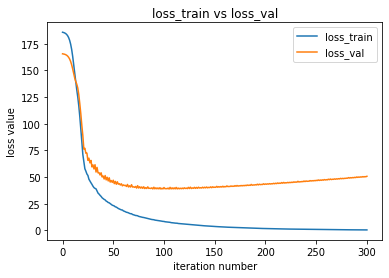

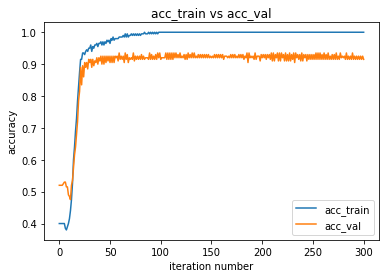

In [8]:
lrmodel_noregr = fit_logregr(mnistbin_train_x,mnistbin_train_y,
                             mnistbin_val_x,mnistbin_val_y,0,quiet=False)
plot_logregr_training(lrmodel_noregr)

**QUESTION 3**

it 0: loss = 176.0, acc = 0.58, ||dloss||^2 = 2.047e+04, step_size = 1e-06
       loss_val = 182.2055, acc_val = 0.54
it 10: loss = 172.6, acc = 0.6, ||dloss||^2 = 1.908e+04, step_size = 5.767e-05
       loss_val = 179.8818, acc_val = 0.55
it 20: loss = 102.0, acc = 0.91, ||dloss||^2 = 2.594e+03, step_size = 0.003325
       loss_val = 120.0412, acc_val = 0.81
it 30: loss = 69.64, acc = 0.94, ||dloss||^2 = 913.9, step_size = 0.001498
       loss_val = 89.7889, acc_val = 0.88
it 40: loss = 62.24, acc = 0.94, ||dloss||^2 = 2.452e+03, step_size = 0.0027
       loss_val = 84.7056, acc_val = 0.87
it 50: loss = 56.72, acc = 0.96, ||dloss||^2 = 342.1, step_size = 0.002432
       loss_val = 77.3126, acc_val = 0.90
it 60: loss = 53.66, acc = 0.96, ||dloss||^2 = 138.3, step_size = 0.002192
       loss_val = 74.1446, acc_val = 0.91
it 70: loss = 51.94, acc = 0.96, ||dloss||^2 = 161.5, step_size = 0.001975
       loss_val = 72.8634, acc_val = 0.91
it 80: loss = 50.88, acc = 0.96, ||dloss||^2 = 201.

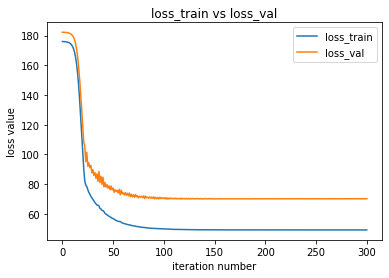

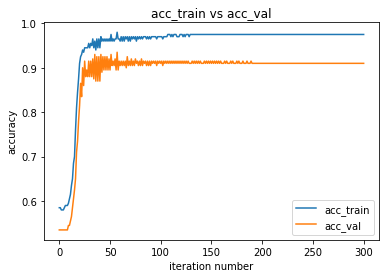

In [9]:
lrmodel_regr = fit_logregr(mnistbin_train_x,mnistbin_train_y,
                           mnistbin_val_x,mnistbin_val_y,10.0,quiet=False)
plot_logregr_training(lrmodel_regr)

## Investigate the models

Visualize the weights of the regularized and unregularized logistic regression model using the `display_mnist_digit` function.

**QUESTION 4**

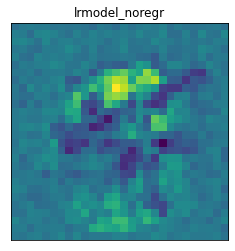

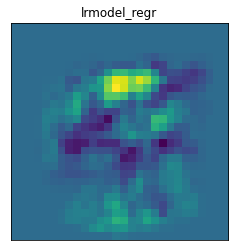

In [10]:
# TODO: show images representing the weights of the two classes
display_mnist_digit(lrmodel_noregr['theta'][: -1],lbl='lrmodel_noregr')
plt.show()
display_mnist_digit(lrmodel_regr['theta'][: -1],lbl='lrmodel_regr')
plt.show()

Find and visualize some interesting examples from the validation set.

**QUESTION 5** and **QUESTION 6**

Top 4 best prob for nonregr_correct


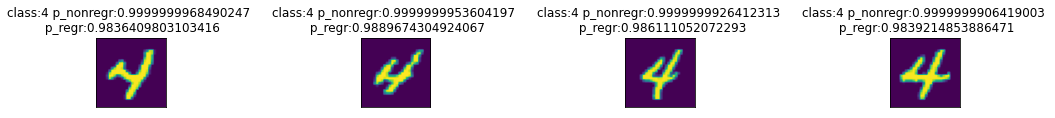

Top 4 worst prob for nonregr_correct


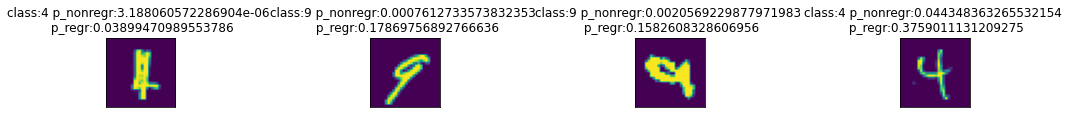

Top 4 best prob for regr_correct


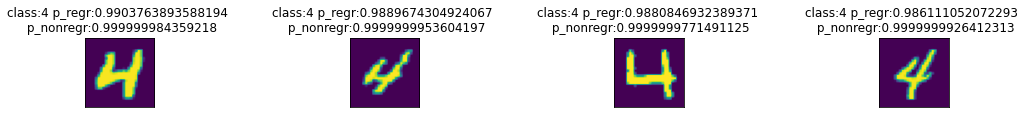

Top 4 worst prob for regr_correct


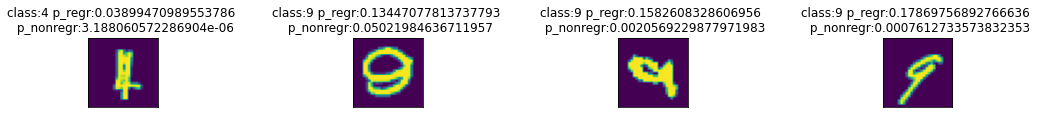

Top 4 closest to 0.5 in nonregr


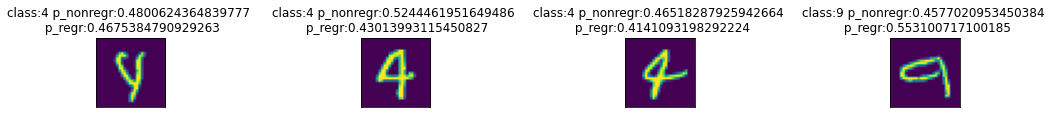

Top 4 closest to 0.5 in regr


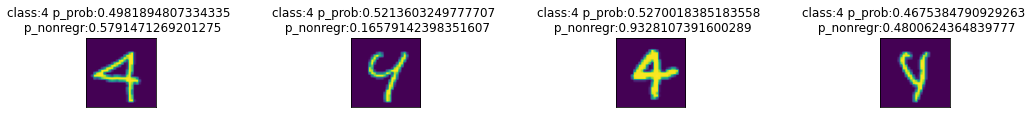

In [11]:
## Evaluate the log probabilities under the model for each class of the
# validation data.
val_noregr_lps = logregr_logprob(mnistbin_val_x,lrmodel_noregr['theta'])
val_regr_lps = logregr_logprob(mnistbin_val_x,lrmodel_regr['theta'])

# TODO: Sort examples in the validation set according to probability of the
# correct class.  Then show the four images with the lowest probability of the
# correct class and the four images with the highest probabilities of the
# correct class.  For each image include in it's title the probability of the
# correct class with and without regularization and which is the correct class,
# 4 or 9.



nonregr_correct = {}
regr_correct = {}

for i in range(len(mnistbin_val_x)):
  if mnistbin_val_y[i] == True:
    nonregr_correct[i] = val_noregr_lps[i][1]
    regr_correct[i] = val_regr_lps[i][1]
  if mnistbin_val_y[i] == False:
    nonregr_correct[i] = val_noregr_lps[i][0]
    regr_correct[i] = val_regr_lps[i][0]
original_nonregr_correct = nonregr_correct
original_regr_correct = regr_correct

nonregr_correct = sorted(nonregr_correct.items(), key=lambda kv: kv[1])
regr_correct = sorted(regr_correct.items(), key=lambda kv: kv[1])
model_9_4 = np.where(mnistbin_val_y,'9','4')





print('Top 4 best prob for nonregr_correct')
plt.subplots_adjust(left=1, bottom=1, right=3, top=3, wspace=2.8, hspace=None)
plt.subplot(1, 4, 1)
tuple_nonr_best_1 = nonregr_correct[len(nonregr_correct)-1]
display_mnist_digit(mnistbin_val_x[tuple_nonr_best_1[0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[tuple_nonr_best_1[0]],  np.exp(tuple_nonr_best_1[1]),
                                                                                                                                     np.exp(original_regr_correct[tuple_nonr_best_1[0]])))
plt.subplot(1, 4, 2)
tuple_nonr_best_2 = nonregr_correct[len(nonregr_correct)-2]
display_mnist_digit(mnistbin_val_x[tuple_nonr_best_2[0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[tuple_nonr_best_2[0]],  np.exp(tuple_nonr_best_2[1]),
                                                                                                                                     np.exp(original_regr_correct[tuple_nonr_best_2[0]])))
plt.subplot(1, 4, 3)
tuple_nonr_best_3 = nonregr_correct[len(nonregr_correct)-3]
display_mnist_digit(mnistbin_val_x[tuple_nonr_best_3[0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[tuple_nonr_best_3[0]],  np.exp(tuple_nonr_best_3[1]),
                                                                                                                                     np.exp(original_regr_correct[tuple_nonr_best_3[0]])))
plt.subplot(1, 4, 4)
tuple_nonr_best_4 = nonregr_correct[len(nonregr_correct)-4]
display_mnist_digit(mnistbin_val_x[tuple_nonr_best_4[0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[tuple_nonr_best_4[0]],  np.exp(tuple_nonr_best_4[1]),
                                                                                                                                     np.exp(original_regr_correct[tuple_nonr_best_4[0]])))
plt.show()

print('Top 4 worst prob for nonregr_correct')
plt.subplots_adjust(left=1, bottom=1, right=3, top=3, wspace=2.8, hspace=None)

plt.subplot(1, 4, 1)
tuple_nonr_worst_1 = nonregr_correct[0]
display_mnist_digit(mnistbin_val_x[tuple_nonr_worst_1[0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[tuple_nonr_worst_1[0]],  np.exp(tuple_nonr_worst_1[1]),
                                                                                                                                     np.exp(original_regr_correct[tuple_nonr_worst_1[0]])))
plt.subplot(1, 4, 2)
tuple_nonr_worst_2 = nonregr_correct[1]
display_mnist_digit(mnistbin_val_x[tuple_nonr_worst_2[0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[tuple_nonr_worst_2[0]],  np.exp(tuple_nonr_worst_2[1]),
                                                                                                                                     np.exp(original_regr_correct[tuple_nonr_worst_2[0]])))
plt.subplot(1, 4, 3)
tuple_nonr_worst_3 = nonregr_correct[2]
display_mnist_digit(mnistbin_val_x[tuple_nonr_worst_3[0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[tuple_nonr_worst_3[0]],  np.exp(tuple_nonr_worst_3[1]),
                                                                                                                                     np.exp(original_regr_correct[tuple_nonr_worst_3[0]])))
plt.subplot(1, 4, 4)
tuple_nonr_worst_4 = nonregr_correct[3]
display_mnist_digit(mnistbin_val_x[tuple_nonr_worst_4[0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[tuple_nonr_worst_4[0]],  np.exp(tuple_nonr_worst_4[1]),
                                                                                                                               np.exp(original_regr_correct[tuple_nonr_worst_4[0]])))    
plt.show()




print('Top 4 best prob for regr_correct')
plt.subplots_adjust(left=1, bottom=1, right=3, top=3, wspace=2.8, hspace=None)
plt.subplot(1, 4, 1)
tuple_r_best_1 = regr_correct[len(regr_correct)-1]
display_mnist_digit(mnistbin_val_x[tuple_r_best_1[0]],lbl='class:{} p_regr:{} \n p_nonregr:{}'.format(model_9_4[tuple_r_best_1[0]],  np.exp(tuple_r_best_1[1]),
                                                                                                                                     np.exp(original_nonregr_correct[tuple_r_best_1[0]])))
plt.subplot(1, 4, 2)
tuple_r_best_2 = regr_correct[len(regr_correct)-2]
display_mnist_digit(mnistbin_val_x[tuple_r_best_2[0]],lbl='class:{} p_regr:{} \n p_nonregr:{}'.format(model_9_4[tuple_r_best_2[0]],  np.exp(tuple_r_best_2[1]),
                                                                                                                                     np.exp(original_nonregr_correct[tuple_r_best_2[0]])))
plt.subplot(1, 4, 3)
tuple_r_best_3 = regr_correct[len(regr_correct)-3]
display_mnist_digit(mnistbin_val_x[tuple_r_best_3[0]],lbl='class:{} p_regr:{} \n p_nonregr:{}'.format(model_9_4[tuple_r_best_3[0]],  np.exp(tuple_r_best_3[1]),
                                                                                                                                     np.exp(original_nonregr_correct[tuple_r_best_3[0]])))
plt.subplot(1, 4, 4)
tuple_r_best_4 = regr_correct[len(regr_correct)-4]
display_mnist_digit(mnistbin_val_x[tuple_r_best_4[0]],lbl='class:{} p_regr:{} \n p_nonregr:{}'.format(model_9_4[tuple_r_best_4[0]],  np.exp(tuple_r_best_4[1]),
                                                                                                                                     np.exp(original_nonregr_correct[tuple_r_best_4[0]])))
plt.show()

print('Top 4 worst prob for regr_correct')
plt.subplots_adjust(left=1, bottom=1, right=3, top=3, wspace=2.8, hspace=None)
plt.subplot(1, 4, 1)
tuple_r_worst_1 = regr_correct[0]
display_mnist_digit(mnistbin_val_x[tuple_r_worst_1[0]],lbl='class:{} p_regr:{} \n p_nonregr:{}'.format(model_9_4[tuple_r_worst_1[0]],  np.exp(tuple_r_worst_1[1]),
                                                                                                                                     np.exp(original_nonregr_correct[tuple_r_worst_1[0]])))
plt.subplot(1, 4, 2)
tuple_r_worst_2 = regr_correct[1]
display_mnist_digit(mnistbin_val_x[tuple_r_worst_2[0]],lbl='class:{} p_regr:{} \n p_nonregr:{}'.format(model_9_4[tuple_r_worst_2[0]],  np.exp(tuple_r_worst_2[1]),
                                                                                                                                     np.exp(original_nonregr_correct[tuple_r_worst_2[0]])))
plt.subplot(1, 4, 3)
tuple_r_worst_3 = regr_correct[2]
display_mnist_digit(mnistbin_val_x[tuple_r_worst_3[0]],lbl='class:{} p_regr:{} \n p_nonregr:{}'.format(model_9_4[tuple_r_worst_3[0]],  np.exp(tuple_r_worst_3[1]),
                                                                                                                                     np.exp(original_nonregr_correct[tuple_r_worst_3[0]])))
plt.subplot(1, 4, 4)
tuple_r_worst_4 = regr_correct[3]
display_mnist_digit(mnistbin_val_x[tuple_r_worst_4[0]],lbl='class:{} p_regr:{} \n p_nonregr:{}'.format(model_9_4[tuple_r_worst_4[0]],  np.exp(tuple_r_worst_4[1]),
                                                                                                                                     np.exp(original_nonregr_correct[tuple_r_worst_4[0]])))
plt.show()





# TODO: Sort examples in the validation set according to the absolute difference
# between the probability of the correct class and 0.5.  Then show the four
# images whose probability of correct class is closest to 0.5.  For each image
# include in it's title the probability of the correct class with and without
# regularization and which is the correct class, 4 or 9.
nonregr_closed = {}
regr_closed = {}
for i in range(len(mnistbin_val_x)):
  if mnistbin_val_y[i] == True:
    nonregr_closed[i] = np.abs(np.exp(val_noregr_lps[i][1]) - 0.5)
    regr_closed[i] = np.abs(np.exp(val_regr_lps[i][1]) - 0.5)
  if mnistbin_val_y[i] == False:
    nonregr_closed[i] = np.abs(np.exp(val_noregr_lps[i][0]) - 0.5)
    regr_closed[i] = np.abs(np.exp(val_regr_lps[i][0]) - 0.5)
#the smallest is the closest to log 0.5
nonregr_closed = sorted(nonregr_closed.items(), key=lambda kv: kv[1])
regr_closed = sorted(regr_closed.items(), key=lambda kv: kv[1])


print('Top 4 closest to 0.5 in nonregr')
plt.subplots_adjust(left=1, bottom=1, right=3, top=3, wspace=2.8, hspace=None)
plt.subplot(1, 4, 1)
display_mnist_digit(mnistbin_val_x[nonregr_closed[0][0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[nonregr_closed[0][0]], np.exp(original_nonregr_correct[nonregr_closed[0][0]]),
                                                                                                         np.exp(original_regr_correct[nonregr_closed[0][0]])))                                                                                          
plt.subplot(1, 4, 2)
display_mnist_digit(mnistbin_val_x[nonregr_closed[1][0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[nonregr_closed[1][0]], np.exp(original_nonregr_correct[nonregr_closed[1][0]]),
                                                                                                         np.exp(original_regr_correct[nonregr_closed[1][0]])))
plt.subplot(1, 4, 3)
display_mnist_digit(mnistbin_val_x[nonregr_closed[2][0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[nonregr_closed[2][0]], np.exp(original_nonregr_correct[nonregr_closed[2][0]]),
                                                                                                         np.exp(original_regr_correct[nonregr_closed[2][0]])))
plt.subplot(1, 4, 4)
display_mnist_digit(mnistbin_val_x[nonregr_closed[3][0]],lbl='class:{} p_nonregr:{} \n p_regr:{}'.format(model_9_4[nonregr_closed[3][0]], np.exp(original_nonregr_correct[nonregr_closed[3][0]]),
                                                                                                         np.exp(original_regr_correct[nonregr_closed[3][0]])))
plt.show()


print('Top 4 closest to 0.5 in regr')
plt.subplots_adjust(left=1, bottom=1, right=3, top=3, wspace=2.8, hspace=None)
plt.subplot(1, 4, 1)
display_mnist_digit(mnistbin_val_x[regr_closed[0][0]],lbl='class:{} p_prob:{} \n p_nonregr:{}'.format(model_9_4[regr_closed[0][0]], np.exp(original_regr_correct[regr_closed[0][0]]),
                                                                                                      np.exp(original_nonregr_correct[regr_closed[0][0]])))
plt.subplot(1, 4, 2)
display_mnist_digit(mnistbin_val_x[regr_closed[1][0]],lbl='class:{} p_prob:{} \n p_nonregr:{}'.format(model_9_4[regr_closed[1][0]], np.exp(original_regr_correct[regr_closed[1][0]]),
                                                                                                      np.exp(original_nonregr_correct[regr_closed[1][0]])))
plt.subplot(1, 4, 3)
display_mnist_digit(mnistbin_val_x[regr_closed[2][0]],lbl='class:{} p_prob:{} \n p_nonregr:{}'.format(model_9_4[regr_closed[2][0]], np.exp(original_regr_correct[regr_closed[2][0]]),
                                                                                                      np.exp(original_nonregr_correct[regr_closed[2][0]])))
plt.subplot(1, 4, 4)
display_mnist_digit(mnistbin_val_x[regr_closed[3][0]],lbl='class:{} p_prob:{} \n p_nonregr:{}'.format(model_9_4[regr_closed[3][0]], np.exp(original_regr_correct[regr_closed[3][0]]),
                                                                                                      np.exp(original_nonregr_correct[regr_closed[3][0]])))
plt.show()





# Step 3: Run LR again with a different set of digit classes
This time, use the digits 0 and 1.

**QUESTION 7**

59.5% of the training data is class True, corresponding to 119 data points


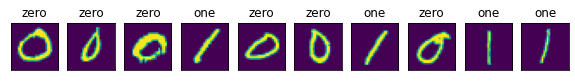

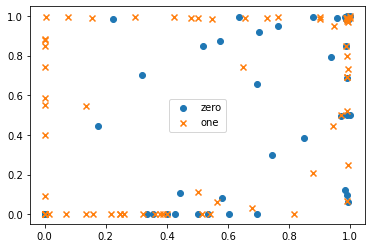

it 0: loss = 196.3, acc = 0.36, ||dloss||^2 = 9.298e+04, step_size = 1e-06
       loss_val = 303.9690, acc_val = 0.37
it 10: loss = 181.3, acc = 0.43, ||dloss||^2 = 8.275e+04, step_size = 5.767e-05
       loss_val = 279.0045, acc_val = 0.41
it 20: loss = 49.1, acc = 1.0, ||dloss||^2 = 1.242e+03, step_size = 0.003325
       loss_val = 58.7708, acc_val = 1.00
it 30: loss = 11.44, acc = 1.0, ||dloss||^2 = 1.741, step_size = 0.01198
       loss_val = 14.8671, acc_val = 1.00
it 40: loss = 11.3, acc = 1.0, ||dloss||^2 = 6.643, step_size = 0.0216
       loss_val = 14.7401, acc_val = 1.00
it 50: loss = 11.15, acc = 1.0, ||dloss||^2 = 1.933, step_size = 0.01946
       loss_val = 14.6862, acc_val = 1.00
it 60: loss = 11.05, acc = 1.0, ||dloss||^2 = 1.095, step_size = 0.01753
       loss_val = 14.6356, acc_val = 1.00
it 70: loss = 10.96, acc = 1.0, ||dloss||^2 = 1.371, step_size = 0.0158
       loss_val = 14.5829, acc_val = 1.00
it 80: loss = 10.89, acc = 1.0, ||dloss||^2 = 0.8942, step_size = 0.

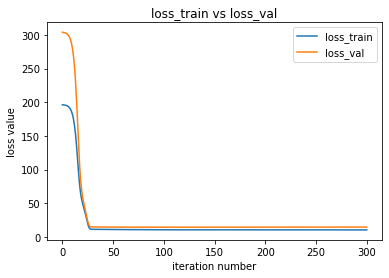

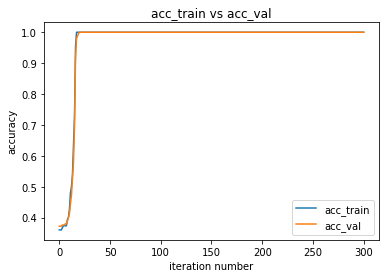

Random sample


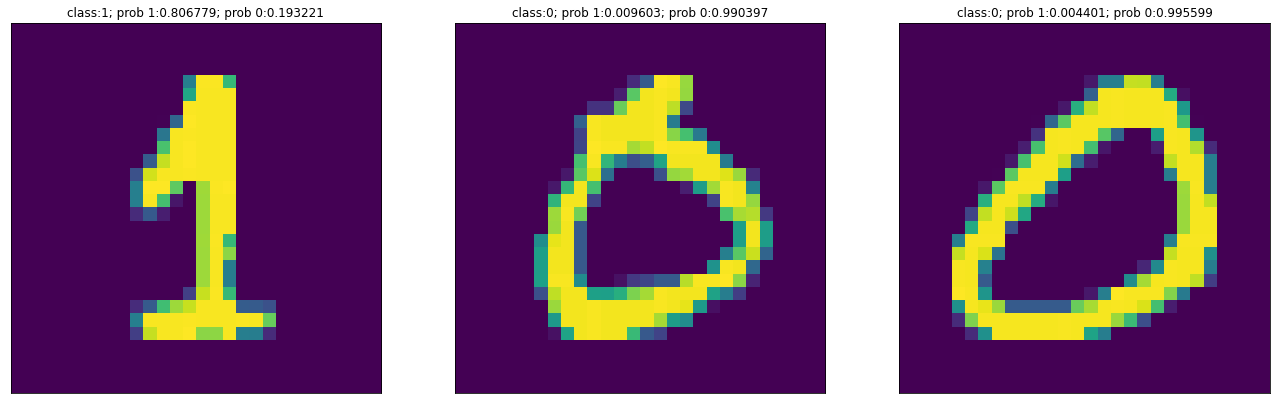

In [13]:
# TODO: Use the `binary_mnist` function to partition the dataset differently and
# follow the same basic steps as above.  First, visualize a few images from the
# new dataset to get a sense.  Then run regularized logistic regression on this
# new dataset, visualize the training and validation performance curves and
# print results.  Finally, visualize a few sample images and their predicted
# class probabilities and true labels.
mnistbin_train_x_new,mnistbin_train_y_new,mnistbin_val_x_new,mnistbin_val_y_new = binary_mnist(0,1,N_train=150, N_val = 250)


print('{}% of the training data is class True, corresponding to {} data points'.format(100*np.sum(mnistbin_train_y)/len(mnistbin_train_y),np.sum(mnistbin_train_y)))

# Visualize a few images
np.random.seed(0)
num_digits = 10
plt.figure(figsize=(10,5))
for i in range(num_digits):
  ind = np.random.randint(0,mnistbin_train_x_new.shape[0])
  plt.subplot(1,num_digits,i+1)
  display_mnist_digit(mnistbin_train_x_new[ind,:],
                      'zero' if mnistbin_train_y_new[ind] else 'one')

# Construct a scatter plot of two arbitrary dimensions
vis_dims = (211,238)
plt.figure()
plt.scatter(mnistbin_train_x_new[mnistbin_train_y_new==True][:,vis_dims[0]],
            mnistbin_train_x_new[mnistbin_train_y_new==True][:,vis_dims[1]],
            marker='o', label='zero')
plt.scatter(mnistbin_train_x_new[mnistbin_train_y_new==False][:,vis_dims[0]],
            mnistbin_train_x_new[mnistbin_train_y_new==False][:,vis_dims[1]],
            marker='x', label='one')
plt.legend()
plt.show()


lrmodel_regr_new = fit_logregr(mnistbin_train_x_new,mnistbin_train_y_new,
                           mnistbin_val_x_new,mnistbin_val_y_new,10.0,quiet=False)
plot_logregr_training(lrmodel_regr_new)


model_1_0 = np.where(mnistbin_val_y_new,'0','1')
val_regr_lps = logregr_logprob(mnistbin_val_x_new,lrmodel_regr_new['theta'])

print('Random sample')
plt.subplots_adjust(left=1, bottom=1, right=7, top=7, wspace=None, hspace=None)
plt.subplot(1, 6, 1)
display_mnist_digit(mnistbin_val_x_new[30],lbl='class:{}; prob 1:{:2f}; prob 0:{:2f}'.format(model_1_0[30], np.exp(val_regr_lps[30][0]), np.exp(val_regr_lps[30][1])))
plt.subplot(1, 6, 2)
display_mnist_digit(mnistbin_val_x_new[12],lbl='class:{}; prob 1:{:2f}; prob 0:{:2f}'.format(model_1_0[12], np.exp(val_regr_lps[12][0]), np.exp(val_regr_lps[12][1])))
plt.subplot(1, 6, 3)
display_mnist_digit(mnistbin_val_x_new[5],lbl='class:{}; prob 1:{:2f}; prob 0:{:2f}'.format(model_1_0[5], np.exp(val_regr_lps[5][0]), np.exp(val_regr_lps[5][1])))

plt.show()